In [1]:
import matplotlib
%matplotlib inline

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches

from sklearn.decomposition import PCA

sns.set_context('poster')
sns.set_style('white')

pd.options.mode.chained_assignment = None  # default='warn'

# Считываем данные

In [2]:
r = np.genfromtxt("4ecoli_with_pure_samples_EDL/matrices/R_all", dtype=int, delimiter=' ')
x = np.genfromtxt("4ecoli_with_pure_samples_EDL/matrices/X_all", dtype=int, delimiter=' ')
print("%s sites" % len(r))

115144 sites


Читаем маску и удаляем первые 4 колонки:

In [3]:
mask = x[:, 0:4]
mask[mask > 0] = 1

r = np.delete(r, [0, 1, 2, 3], axis=1)
x = np.delete(x, [0, 1, 2, 3], axis=1)

## Фильтрация и преобразование

Удаляем снипы с покрытием, близким к 0 или 1:

In [4]:
Ncut = 5
print("Delete zero and almost zero profiles:")
good_ind = [i for i in range(np.shape(x)[0]) 
            if not ((np.abs(r[i, :] - x[i, :]) <= Ncut).all() or (x[i, :] <= Ncut).all())]
print(len(good_ind), "remained")

x = x[good_ind, :]
r = r[good_ind, :]
mask = mask[good_ind, :]

Delete zero and almost zero profiles:
114862 remained


#### Нормализация
Берем либо вектор VAF, либо вектор (1 - VAF) в зависимости от того, чья норма больше.

In [5]:
def normalize(x, r):
    M = np.divide(x, r)
    M_norm = np.full_like(M, 0)
    for i in range(np.shape(M)[0]):
        rev = 1 - M[i, :]
        if np.dot(M[i, :], M[i, :]) > np.dot(rev, rev):
            M_norm[i, :] = rev
        else:
            M_norm[i, :] = M[i, :]
    return M_norm

f = normalize(x, r)

Рисуем получившиеся фичи на главных компонентах.

In [6]:
def draw_PCA(f_pca, black_points=None):
    
    #plt.figure(figsize=(10, 6))
    plt.figure(figsize=(15, 9))
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")

    plt.scatter(f_pca[:, 0], f_pca[:, 1], s=30, linewidth=0, alpha=0.3);
    if black_points is not None:
        plt.scatter(f_pca[black_points, 0], f_pca[black_points, 1], s=40, linewidth=0, c="black", alpha=1);
        plt.title("%s / %s points" % (np.sum(black_points), len(f_pca)))
    else:
        plt.title("%s points" % len(f_pca))

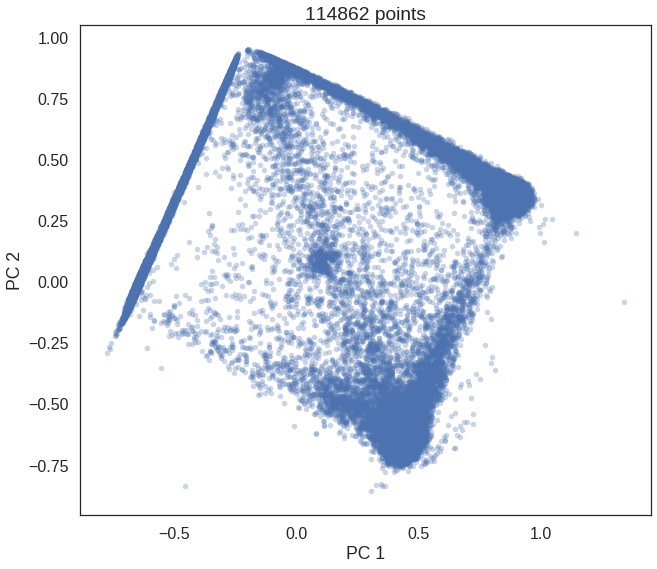

In [7]:
f_pca = PCA(n_components=2).fit(f).transform(f)
draw_PCA(f_pca)

Отметим те точки, у которых неплохое покрытие по R. (Но пока их выкидывать не будем.)

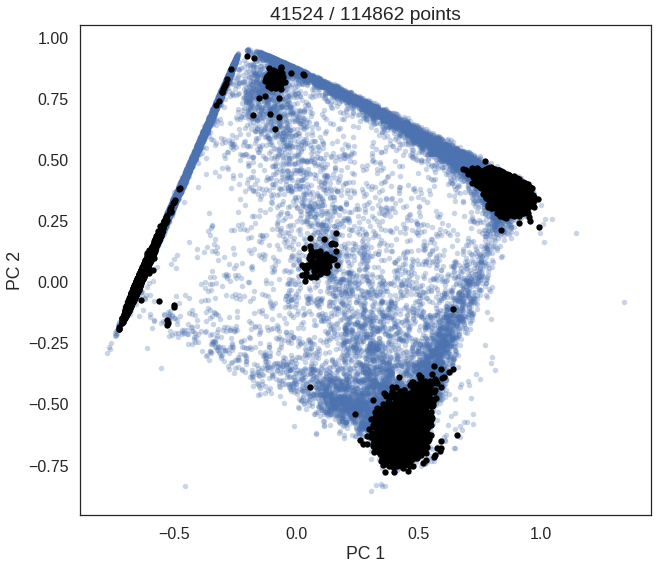

In [8]:
def filter_by_coverage(cur_r, bad_percent, bad_samples):
    def filter_row(row):
        num_of_samples = len(row)
        valid = np.sum(np.array(([(min_coverage < row) & (row < max_coverage)])))
        return num_of_samples - valid <= bad_samples

    min_coverage = np.percentile(cur_r, bad_percent, axis=0)
    max_coverage = np.percentile(cur_r, 100-bad_percent, axis=0)
    good_coverage = np.array([filter_row(row) for row in cur_r])
    return good_coverage

draw_PCA(f_pca, filter_by_coverage(r, 15, 2))

# Рисуем картинки

(Вспомогательная процедура, которая рисует легенду с обозначением цветов.)

In [9]:
def draw_legend(class_colours, classes, right=False):
    recs = []
    for i in range(0, len(classes)):
        recs.append(mpatches.Rectangle((0,0), 1, 1, fc=class_colours[i]))
    if right:
        plt.legend(recs, classes, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    else:
        plt.legend(recs, classes)

## Уникальные и не очень SNP

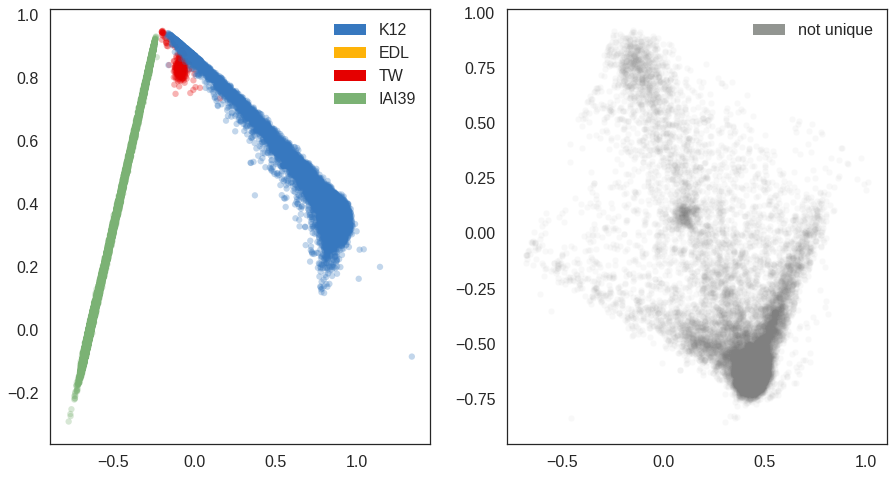

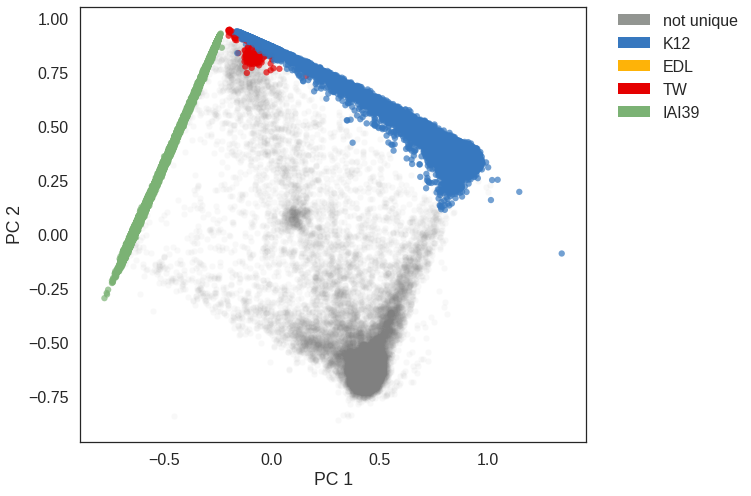

In [10]:
names = ["K12", "EDL", "TW", "IAI39"]

def plot_unique_and_not(f_pca, mask, names):
    unique = []
    for m in mask:
        if np.sum(m) == 1:
            index = np.where(m == 1)[0][0]
            unique.append(index)
        else:
            unique.append(-1)

    # split data in 2 groups
    df = pd.DataFrame({'pc1':f_pca[:, 0], 'pc2':f_pca[:, 1], 'unique':unique})
    df_not_unique = df.loc[df['unique'] == -1]
    df_unique = df.loc[df['unique'] != -1]

    colors = ["windows blue", "amber", "red", "faded green", "dusty purple"]
    color_palette = sns.xkcd_palette(colors)
    cluster_colors = [color_palette[x] for x in df_unique["unique"]]

    plt.figure(figsize=(15, 8))
    ax = plt.gca()
    ax.set_aspect('equal')
    # only uniques
    plt.subplot(1, 2, 1)
    plt.scatter(df_unique["pc1"], df_unique["pc2"], s=40, linewidth=0, c=cluster_colors, alpha=0.3);
    draw_legend(color_palette, names)
    # only non-uniques
    plt.subplot(1, 2, 2)
    plt.scatter(df_not_unique["pc1"], df_not_unique["pc2"], s=40, linewidth=0, c="grey", alpha=0.05)
    draw_legend(sns.xkcd_palette(["grey"]), ["not unique"])

    # both types
    plt.figure(figsize=(15, 8))
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.scatter(df_not_unique["pc1"], df_not_unique["pc2"], s=40, linewidth=0, c="grey", alpha=0.05)
    plt.scatter(df_unique["pc1"], df_unique["pc2"], s=40, linewidth=0, c=cluster_colors, alpha=0.7);
    draw_legend(sns.xkcd_palette(["grey"] + colors), ["not unique"] + names, right=True)
    
plot_unique_and_not(f_pca, mask, names)

## В сколькиx стрейнах встречается SNP

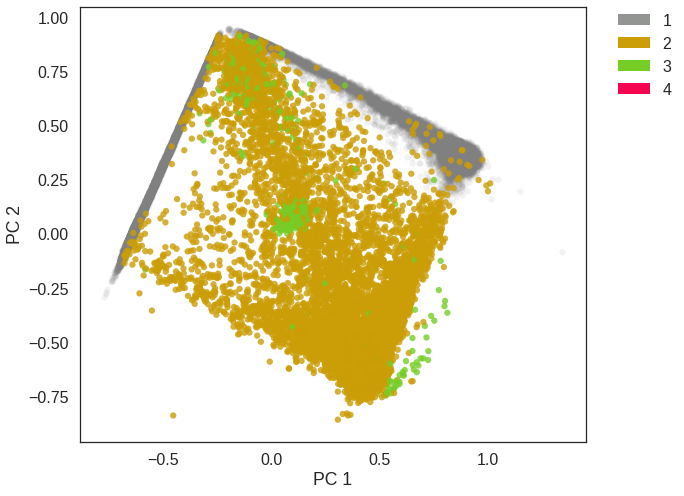

In [11]:
def plot_how_much_strains(f_pca, mask):
    num_of_strains = len(mask[0])
    counts = [np.sum(m) for m in mask]

    df = pd.DataFrame({'pc1':f_pca[:, 0], 'pc2':f_pca[:, 1], 'counts':counts})
    df_not_unique = df.loc[df['counts'] > 1]
    df_unique = df.loc[df['counts'] == 1]

    colors = ["grey", "yellow ochre", "apple green", "pink red"]
    color_palette = sns.xkcd_palette(colors)
    cluster_colors = [color_palette[x - 1] for x in df_not_unique["counts"]]

    plt.figure(figsize=(15, 8))
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")

    plt.scatter(df_unique["pc1"], df_unique["pc2"], s=40, linewidth=0, c="grey", alpha=0.1)
    plt.scatter(df_not_unique["pc1"], df_not_unique["pc2"], s=40, linewidth=0, c=cluster_colors, alpha=0.8);
    draw_legend(color_palette, [str(i) for i in range(1, num_of_strains+1)], right=True)
    
plot_how_much_strains(f_pca, mask)

## SNP, встречающиеся в комбинации стрейнов

In [33]:
 def plot_shared_snps(f_pca, mask, names, draw_all=False, title="", legend=True):
    combs = []
    combs_nums = []
    combinations = []

    for m in mask:
        if not draw_all:
            if not (np.sum(m) > 1):
                combinations.append(-1)
                continue
        cur = ""
        for i in range(len(m)):
            if m[i] == 1:
                if cur != "":
                    cur += " + "
                cur += names[i]                    
        if cur not in combs:
            combs.append(cur)
            combs_nums.append(0)
        combs_nums[combs.index(cur)] += 1
        combinations.append(combs.index(cur))

    df = pd.DataFrame({'pc1':f_pca[:, 0], 'pc2':f_pca[:, 1], 'combination':combinations})
    df_valid = df.loc[df['combination'] != -1]

    # reoder combinations by sizes of groups
    order = sorted(zip(combs_nums, combs, range(12)), reverse=True)
    new_comb_order = [0] * (2 ** len(mask[0]))
    new_comb_names = [] 
    for i in range(len(order)):
        old_order = order[i][2]
        new_comb_order[old_order] = i
        #new_comb_names.append('{:5d}'.format(order[i][0]) + '  ' + order[i][1])
        new_comb_names.append(order[i][1])
    for i in df_valid.index:
        df_valid.loc[i, "combination"] = new_comb_order[df_valid.loc[i, "combination"]]

    # Kelly’s 20 (except the first 2) Colours of Maximum Contrast
    colors = ['yellow', 'purple', 'orange', '#96cde6', 'red', '#c0bd7f', '#7f7e80', '#5fa641', '#d485b2', 
              '#4277b6', '#df8461', '#463397', '#e1a11a', '#91218c', '#e8e948', '#7e1510',
              '#92ae31', '#6f340d', '#d32b1e', '#2b3514']
    color_palette = sns.color_palette(colors)
    cluster_colors = [color_palette[x] for x in df_valid["combination"]]

    plt.figure(figsize=(15, 8))
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.scatter(df_valid["pc1"], df_valid["pc2"], s=40, linewidth=0, c=cluster_colors, alpha=0.6);
    plt.title(title)
    draw_legend(color_palette, new_comb_names, right=True)


In [30]:
#plot_shared_snps(f_pca, mask, names, draw_all=True)

# Без преобразования

In [15]:
f_withoutT = np.divide(x, r)
f_pca_withoutT = PCA(n_components=2).fit(f_withoutT).transform(f_withoutT)

In [16]:
f_pca_withoutT_inv = f_pca_withoutT.copy()
f_pca_withoutT_inv[:,1] *= -1

In [ ]:
draw_PCA(f_pca_withoutT_inv)

In [ ]:
draw_PCA(f_pca_withoutT_inv, filter_by_coverage(r, 15, 2))

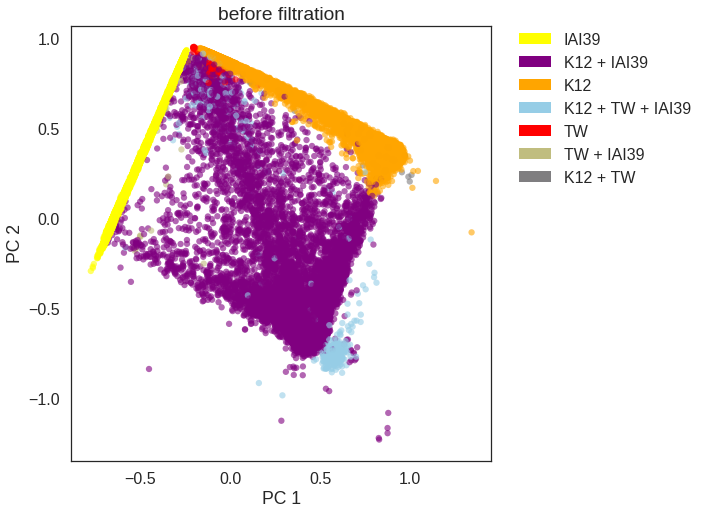

In [34]:
plot_shared_snps(f_pca_withoutT_inv, mask, names, draw_all=True, title="before filtration", legend=False)

# С фильтрацией по покрытию и без преобразования

In [17]:
good_coverage = filter_by_coverage(r, 15, 2)

mask_filtered = mask[good_coverage, :]

f_withoutT_filtered = np.divide(x, r)[good_coverage, :]

f_pca_withoutT_filtered = PCA(n_components=2).fit(f_withoutT_filtered).transform(f_withoutT_filtered)

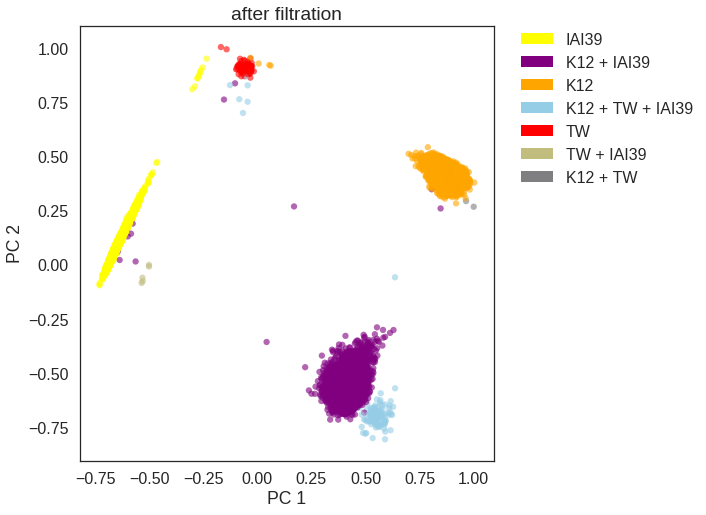

In [35]:
plot_shared_snps(f_pca_withoutT_filtered, mask_filtered, names, draw_all=True, title="after filtration")

In [ ]:
plt.figure(figsize=(15, 8))
    ax = plt.gca()
    ax.set_aspect('equal')
    # only uniques
    plt.subplot(1, 2, 1)
    plt.scatter(df_unique["pc1"], df_unique["pc2"], s=40, linewidth=0, c=cluster_colors, alpha=0.3);
    draw_legend(color_palette, names)
    # only non-uniques
    plt.subplot(1, 2, 2)
    plt.scatter(df_not_unique["pc1"], df_not_unique["pc2"], s=40, linewidth=0, c="grey", alpha=0.05)
    draw_legend(sns.xkcd_palette(["grey"]), ["not unique"])

## Размеры групп

In [18]:
 def sizes_of_groups(mask, names):
    combs = []
    combs_nums = []

    for m in mask:
        cur = ""
        for i in range(len(m)):
            if m[i] == 1:
                if cur != "":
                    cur += " + "
                cur += names[i]                    
        if cur not in combs:
            combs.append(cur)
            combs_nums.append(0)
        combs_nums[combs.index(cur)] += 1

    df = pd.DataFrame({'size':combs_nums, 'description':combs})
    df = df.sort_values(by='size', ascending=False)
    df = df.reset_index(drop=True)
    return df

##### Нефильтрованные данные:

In [19]:
sizes_of_groups(mask, names)

,description,size
0,IAI39,55754
1,K12 + IAI39,30374
2,K12,27833
3,K12 + TW + IAI39,543
4,TW,288
5,TW + IAI39,41
6,K12 + TW,29


##### Фильтрованные:

In [20]:
sizes_of_groups(mask_filtered, names)

,description,size
0,IAI39,20614
1,K12 + IAI39,10576
2,K12,10099
3,K12 + TW + IAI39,126
4,TW,101
5,TW + IAI39,5
6,K12 + TW,3


# Кластеризация

In [21]:
freq1 = [0.75, 0.84, 0, 0.2, 0.35, 0.53, 0.79, 0.71, 0.38, 0.75, 0.41]
freq1_rev = [1 - f for f in freq1]
norm_freq1 = sum([e**2 for e in freq1])
norm_freq1_rev = sum([e**2 for e in freq1_rev])
print(norm_freq1)
print(norm_freq1_rev)
print()

freq1 = [0.71, 0.74, 0, 0.12, 0.18, 0.51, 0.75, 0.63, 0.23, 0.72, 0.37]
freq1_rev = [1 - f for f in freq1]
norm_freq1 = sum([e**2 for e in freq1])
norm_freq1_rev = sum([e**2 for e in freq1_rev])
print(norm_freq1)
print(norm_freq1_rev)

3.7147000000000006
3.2946999999999997

3.0261999999999993
4.106199999999999


In [22]:
plot_shared_snps(f_pca_filtered, mask_filtered, names, draw_all=True)
plot_shared_snps(f_pca_withoutT_filtered, mask_filtered, names, draw_all=True)

NameError: name 'f_pca_filtered' is not defined

In [23]:
import hdbscan
from collections import Counter
from collections import defaultdict
from numpy import random

In [24]:
f_withoutT_filtered = np.divide(x, r)[good_coverage, :]

In [25]:
def sizes_to_probs(s):
    s_log = np.log(s)
    return s_log / s_log.sum()

def subsample_from_cluters(Npoints, data, labels):
    groupby_labels = defaultdict(list)
    for i in range(np.shape(data)[0]):
        groupby_labels[labels[i]].append(i)
    groupby_labels = dict(groupby_labels)

    cluster_size = np.array([len(groupby_labels[i]) for i in groupby_labels.keys()], dtype=int)
    print("clusters sizes", cluster_size)
    cluster_size = Npoints * sizes_to_probs(cluster_size)
    print("\nSubsamplings sizes:")
    print(cluster_size)

    subsamples = {}
    for i in groupby_labels.keys():
        subsample_size = int(round(cluster_size[i]))
        subsample_index = random.choice(groupby_labels[i], size=subsample_size, replace=True).tolist()
        subsamples[i] = subsample_index

    ind = [val for sublist in list(subsamples.values()) for val in sublist]
    random.shuffle(ind)
    return ind

Counter({2: 20618, 4: 10558, 0: 10102, 1: 123, 3: 116, -1: 7})
clusters sizes [111 436 100 103 107]

Subsamplings sizes:
[ 38.13400147  49.21187642  37.2889777   37.52832119  37.83682322]


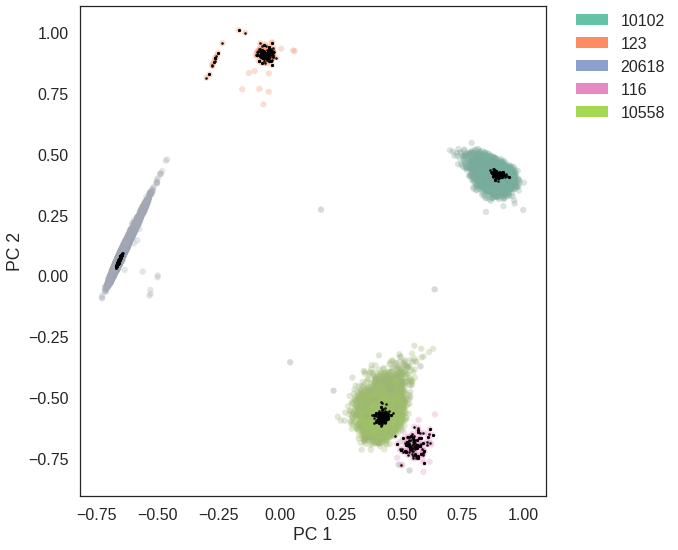

In [27]:
def clusterization(f):
    f_pca = PCA(n_components = 2).fit(f).transform(f)
    
    #N = (int) (len(f) * 0.005)
    #print(N)
    N = 100

    clusterer = hdbscan.HDBSCAN(min_cluster_size=N, min_samples=1).fit(f)
    
    sizes_of_classes = Counter(clusterer.labels_)
    print(sizes_of_classes)
    
    plt.figure(figsize=(15, 9))
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    
    color_palette = sns.color_palette("Set2", 20)
    cluster_colors = [color_palette[x] if x >= 0
                      else (0.5, 0.5, 0.5)
                      for x in clusterer.labels_]
    cluster_member_colors = [sns.desaturate(x, p) for x, p in
                             zip(cluster_colors, clusterer.probabilities_)]
    plt.scatter(f_pca[:, 0], f_pca[:, 1], s=40, linewidth=0, c=cluster_member_colors, alpha=0.3);
    
    # search indexes of exemplars in data
    exemplars = np.concatenate(clusterer.exemplars_)
    f_sorted = np.ascontiguousarray(f).view([('', f.dtype)] * f.shape[-1]).ravel()
    f_sorted.sort()
    exemplars_comp = np.ascontiguousarray(exemplars).view(f_sorted.dtype)
    exemplars_ind = f_sorted.searchsorted(exemplars_comp)
    exemplars_ind = exemplars_ind.flatten()
    exemplars_ind.sort()
    
    plt.scatter(f_pca[exemplars_ind, 0], f_pca[exemplars_ind, 1], s=7, linewidth=0, c="black", alpha=0.9);
    
    f_filtered_pca = f_pca[exemplars_ind]
    r_filtered = r[exemplars_ind]
    x_filtered = x[exemplars_ind]
    subs_ind = subsample_from_cluters(200, f[exemplars_ind], clusterer.labels_[exemplars_ind])
    plt.scatter(f_filtered_pca[subs_ind, 0], f_filtered_pca[subs_ind, 1], s=10, linewidth=0, c="black", alpha=1)
    
    np.savetxt("R_filtered", r_filtered[subs_ind, :], fmt='%s')
    np.savetxt("X_filtered", x_filtered[subs_ind, :], fmt='%s')
    
    labels = [str(sizes_of_classes[x]) for x in range(max(clusterer.labels_)+1)]
    draw_legend(color_palette, labels, right=True)
    
    return clusterer
    
clusterer1 = clusterization(f_withoutT_filtered)

In [ ]:
[len(clusterer1.exemplars_[i]) for i in range(5)]

In [ ]:
for i in range(5):
    print(i, np.round(np.median(clusterer1.exemplars_[i], axis=0), 2))

K12    0.71  0.74  0  0.12  0.18  0.02  0.13  0.63  0.23  0.06  0
EDL    0.25  0.16  1  0.8   0.65  0.47  0.21  0.29  0.62  0.25  0.59
TW     0.03  0.1   0  0.09  0.17  0.02  0.05  0.07  0.15  0.03  0.04
IAI39  0     0     0  0     0     0.49  0.62  0     0     0.66  0.37